# Assignment 3
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using various deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

Data can be downloaded from https://www.kaggle.com/c/facial-keypoints-detection/data

In the following lines we provide a simple solution: a neural net with a single hidden layer. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by extending the baseline model to convolutional neural nets.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout or BatchNorm.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.
    
For developing puposes it is not a bad idea to work with 43x43 images...
    
Advanced suggestions:
+ Use several loss functions (f.e. one computing the MSE of predicted points and another measuring a global deformation of the constellation of points).
+ Can we work in a lower dimensional space for representing points? This could help with hidden points, global deformations, etc.
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

## <font color='red'> MY SOLUTIONS

In [596]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

from numpy import loadtxt

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split


Setting some functions will be usefull for the data processing and for comparing the models. All the models (in h5) and history files (in json) can be found in the folder and have been runned in colab (https://colab.research.google.com/drive/1o0b7TDnJpFCS96l2NZGI69poyeOKycQM#scrollTo=KB5oOz3pTfi1) as to use Google GPU.

In [597]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    plt.imshow(x, cmap='gray')
    plt.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)
    
def load2d(test=False, cols=None):
    X, y = load(test=test, cols=cols) 
    X = np.expand_dims(X, -1)
    return X, y

def model_predict(model_path, x):
    model = load_model(model_path)    
    y_pred = model.predict(x)
    return y_pred
 
def model_summary(model_path):
    model = load_model(model_path)
    return model.summary()    

In [598]:
def loss_plot(hist_path):
    history = eval(open(hist_path).read())
    loss = history['loss']
    val_loss = history['val_loss']
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(loss, linewidth=3, label='train')
    plt.plot(val_loss, linewidth=3, label='valid')
    plt.grid()
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.show()

def loss_comparison(history_paths, labels):
    N = len(history_paths) ; hists = [] ; loss = []
    for i in range(N):
        hists.append(eval(open(history_paths[i]).read()))
    for i in range(N):
        loss.append(hists[i]['val_loss'])
    fig = plt.figure(figsize=(10,7))
    for i in range(N):
        plt.plot(loss[i], linewidth=3, label=labels[i])
    plt.grid()
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log') 
    plt.show()

def image_compare(ypred1, ypred2, label1, label2):
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(hspace=0.001,wspace=0.001,
                    left=0,right=1,bottom=0, top=1)

    Npicture = 5
    count = 1
    for irow in range(Npicture):
        ipic = np.random.choice(X_test.shape[0]) 
        ax = fig.add_subplot(Npicture, 2, count, xticks=[], yticks=[])  
        plot_sample2(X_test[ipic], ypred1[ipic], ax)
        if count < 3:
            ax.set_title(label1)
        count += 1

        ax = fig.add_subplot(Npicture, 2, count, xticks=[], yticks=[])  
        plot_sample2(X_test[ipic],ypred2[ipic],ax)
        if count < 3:
            ax.set_title(label2)
        count += 1
    
    plt.show()    
    
Score_df = pd.DataFrame({"Mse_Train":[], "Mse_Val":[], 
                         "Acc_Train":[], "Acc_Val":[]})

def Score(model_name, hist_path):
    hist = eval(open(hist_path).read())
    Score_df.loc[model_name] = [hist['loss'][-1], hist['val_loss'][-1], 
                           hist['accuracy'][-1], hist['val_accuracy'][-1]]
    return Score_df                         

def plot_sample2(x, y, axis):
    img = x.reshape(96, 96) 
    axis.imshow(img, cmap='gray') 

    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [599]:
df_train = pd.read_csv('training.csv')
df_test = pd.read_csv('test.csv')
df_train.shape, df_test.shape

((7049, 31), (1783, 2))

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

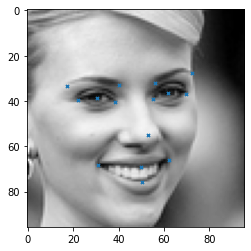

In [600]:
X, y = load()
print("We lost {} samples".format(df_train.shape[0]-X.shape[0]))
plot_sample(X[12],y[12])

## <font color='red'> FULLY CONNECTED MODEL

The first model will be the simplest: a fully connected network with a (96*96) vector as input and the target vector y as output. We use relu as activation function. We will run all the models for one epochs to show that the current configuration works properly.

In [381]:
####
##The code for FC Model:
####


model = Sequential()
model.add(Dense(100, input_dim=9216))
model.add(Activation('relu'))
model.add(Dense(30))

sgd = SGD()
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])

X_exe = X.reshape(2140, 9216)

histDense = model.fit(X_exe, y, epochs=1, batch_size=64, validation_split=0.2)


27/27 [==============================] - 1s 19ms/step - loss: 0.0953 - accuracy: 0.1203 - val_loss: 0.0452 - val_accuracy: 0.0467


In [601]:
model_summary('models/modelDense.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               921700    
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________


After 600 epochs, using a batch size of 64

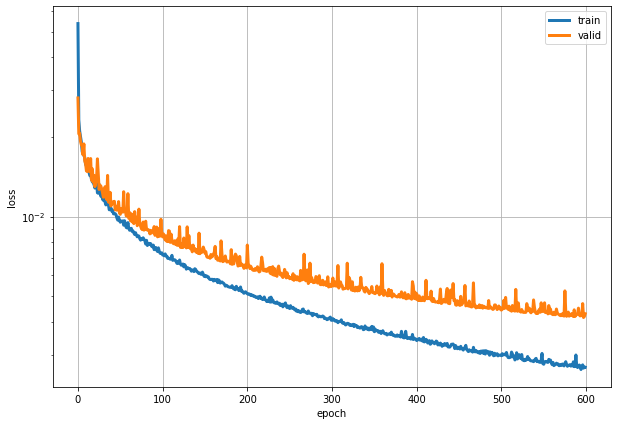

In [602]:
loss_plot('history/histDense.json')

In [486]:
Score('FC', 'history/histDense.json')


,Mse_Train,Mse_Val,Acc_Train,Acc_Val
FC,0.002701,0.004299,0.726051,0.721963


And theese are the results on an unseen set:

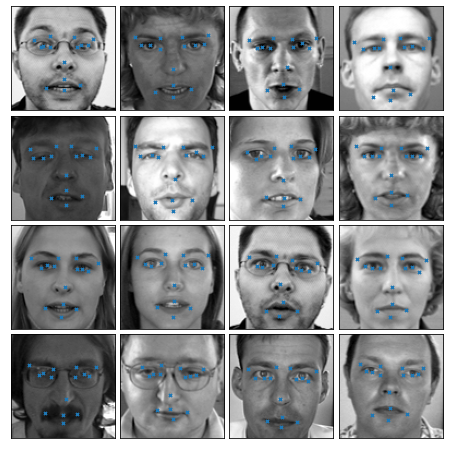

In [603]:
#X_test ,_ = load(test=True)
X_test = X_test.reshape((1783, 96*96))

y_predFC = model_predict('models/modelDense.h5', X_test)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample2(X_test[i], y_predFC[i], ax)

plt.show()

## FULLY CONNECTED + MOMENTUM

We can see that using momentum on the sub gradient descent, we can improove the model in therm of decreasing of the loss function.

In [382]:
####
##The code for Dense Model + Momentum:
####


model = Sequential()
model.add(Dense(100, input_dim=9216))
model.add(Activation('relu'))
model.add(Dense(30))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])

histDense_Mom = model.fit(X_exe, y, epochs=1, validation_split=0.2)


54/54 [==============================] - 0s 8ms/step - loss: 0.0476 - accuracy: 0.4936 - val_loss: 0.0176 - val_accuracy: 0.5023


In [604]:
model_summary('models/modelDense_mom.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               921700    
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________


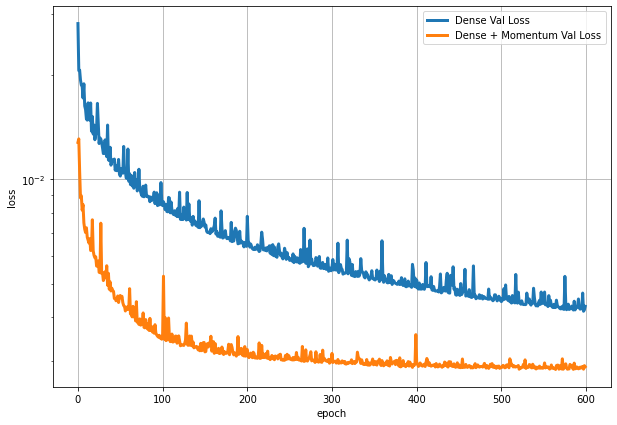

In [605]:
loss_comparison(['history/histDense.json', 'history/histDense_mom.json'], 
                                                ['Dense Val Loss', 'Dense + Momentum Val Loss'])

## <font color='red'> CONVOLUTIONAL NEURAL NETWORK

We will now apply a CNN with the following architecture:

In [606]:
model_summary('models/modelCNN.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 96, 96, 16)        80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 128)        

In [607]:
####
##The code for CNN Model:
####


def CNN(DropOut=False, BatchNorm=False, Last=True):
    model = Sequential()

    model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same",activation="relu",input_shape=(96,96,1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if DropOut == True:
        model.add(Dropout(0.1))
    if BatchNorm == True:
        model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=(5,5) ,activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if DropOut == True:
        model.add(Dropout(0.1))
    if BatchNorm == True:
        model.add(BatchNormalization())  

    model.add(Conv2D(64, kernel_size=(5,5) ,activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if DropOut == True:
        model.add(Dropout(0.2))
    if BatchNorm == True:
        model.add(BatchNormalization())  

    model.add(Conv2D(128, kernel_size=(3,3),activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if DropOut == True:
        model.add(Dropout(0.3))
    if BatchNorm == True:
        model.add(BatchNormalization())  

    model.add(Flatten())
    model.add(Dense(500, activation="relu"))
    if DropOut == True:
        model.add(Dropout(0.4))

    model.add(Dense(128, activation="relu"))
    if Last == True:
        model.add(Dense(30))

    return(model)

In order to apply kernels we need the right shape for the input

In [608]:
X, y = load2d()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

((1712, 96, 96, 1), (428, 96, 96, 1), (1712, 30), (428, 30))

We will first analize how it works changing the learning rate of the SGD, in three different cases: 

LARGE LR

In [386]:
batch_size = 64
epochs = 1

modCNN_LSGD = CNN()

sgd = SGD(lr=1, momentum=0.9, nesterov=True)

modCNN_LSGD.compile(loss='mse', optimizer=sgd)

histCNN_LSGD = modCNN_LSGD.fit(X_train,y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(X_val, y_val))

27/27 [==============================] - 10s 370ms/step - loss: 0.0258 - val_loss: 0.0045


SMALL LR

In [388]:
batch_size = 64
epochs = 1

modCNN_SSGD = CNN()

sgd = SGD(lr=0.0001, momentum=0.9, nesterov=True)

modCNN_SSGD.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])

histCNN_SSGD = modCNN_SSGD.fit(X_train,y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(X_val, y_val))

27/27 [==============================] - 15s 552ms/step - loss: 0.1592 - accuracy: 0.0000e+00 - val_loss: 0.1580 - val_accuracy: 0.0000e+00


USING CALLBACKS WE CAN VARY LR INTO A RANGE

In [391]:
from keras.callbacks import ReduceLROnPlateau

callback_setting_LR = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, mode='auto', 
                       min_delta=0.0001, cooldown=10, min_lr=0.000001)]

modCNN_CLR = CNN()

modCNN_CLR.compile(optimizer='sgd', loss='mse')

historyCNN_LR = modCNN_CLR.fit(X_train, y_train, epochs=epochs, batch_size=64, callbacks = callback_setting_LR, 
                   verbose=2, validation_data=(X_val, y_val))    

27/27 - 12s - loss: 0.1450 - val_loss: 0.1343


After 300 epochs (for this situation) we can see that a very small learning rate is too slow, a big LR is able to converge to the same loss validation value of a changing LR.

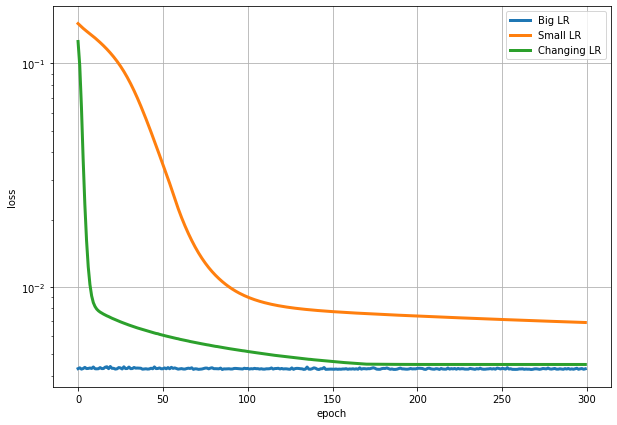

In [609]:
loss_comparison(["history/histCNN_SGD1.json", "history/histCNN_SGD001.json", "history/histCSGD.json"],
               ["Big LR", "Small LR", "Changing LR"])

We can improove the result using Adam as optimizer.

In [421]:
modCNN = CNN()

callback_setting_LR = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, mode='auto', 
                                      min_delta=0.0001, cooldown=10, min_lr=0.000001)]

modCNN.compile(optimizer='adam', loss='mse')

history_CNN = modCNN.fit(X_train, y_train, epochs=epochs, batch_size=64, callbacks = callback_setting_LR, 
                   verbose=2, shuffle=True, validation_data=(X_val, y_val))

27/27 - 11s - loss: 0.0288 - val_loss: 0.0081


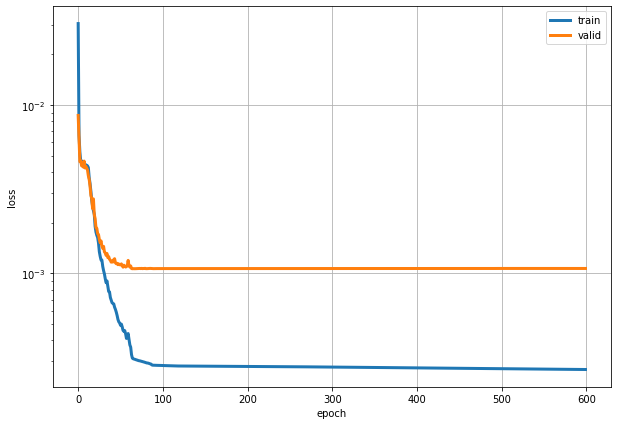

In [610]:
loss_plot('history/histCNN.json')

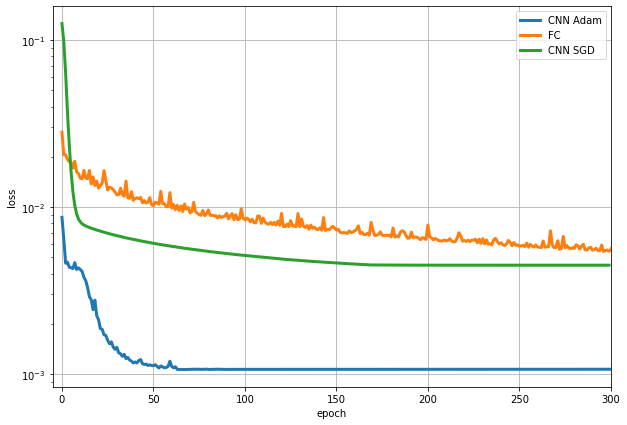

In [611]:
history_paths = ['history/histCNN.json', 'history/histDense.json', "history/histCSGD.json"]
labels = ['CNN Adam', 'FC', 'CNN SGD']

N = len(history_paths) ; hists = [] ; loss = []
for i in range(N):
    hists.append(eval(open(history_paths[i]).read()))
for i in range(N):
    loss.append(hists[i]['val_loss'])
fig = plt.figure(figsize=(10,7))
for i in range(N):
    plt.plot(loss[i], linewidth=3, label=labels[i])
    

plt.grid()
plt.legend()
plt.xlim(-5, 300)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log') 
plt.show()

In [487]:
Score('CNN', 'history/histCNN.json')


,Mse_Train,Mse_Val,Acc_Train,Acc_Val
FC,0.002701,0.004299,0.726051,0.721963
CNN,0.000269,0.001070,0.904790,0.789720


As we can see the CNN model gives a better prediction then the FC model

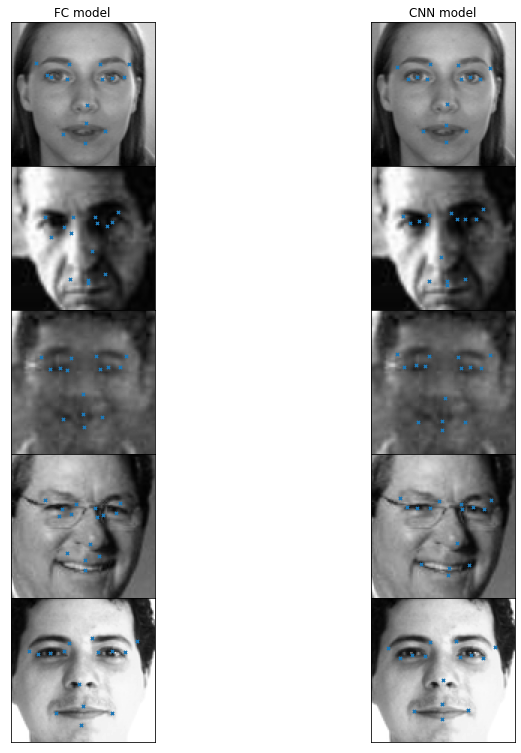

In [490]:
#X_test ,_ = load2d(test=True)

y_predCNN = model_predict('models/modelCNN.h5', X_test)

image_compare(y_predFC, y_predCNN, "FC model", "CNN model")

## DROP OUT

Let's see if we can lower over fitting applying some Drop Out layers on the same CNN architecture.

In [446]:
modCNN_DO = CNN(DropOut=True)
modCNN_DO.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])
histCNN_DO = modCNN_DO.fit(X_train,y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(X_val, y_val))

27/27 [==============================] - 14s 514ms/step - loss: 0.0387 - accuracy: 0.4533 - val_loss: 0.0284 - val_accuracy: 0.6916


In [612]:
model_summary('models/modelCNN_DO.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 16)        80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 64)       

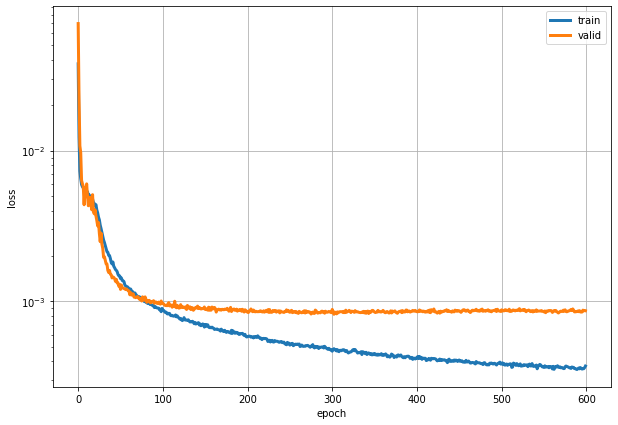

In [613]:
loss_plot('history/histCNN_DO.json')

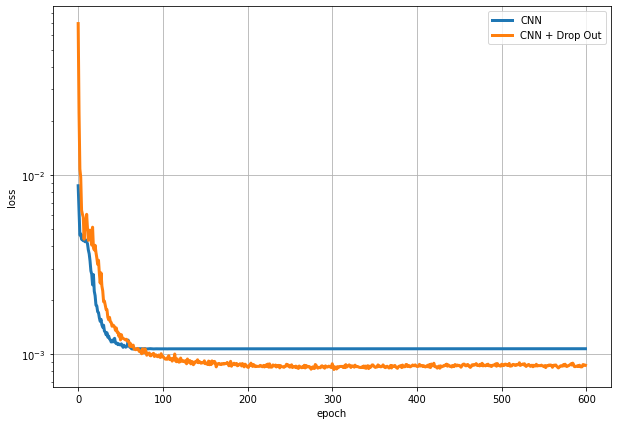

In [614]:
loss_comparison(['history/histCNN.json', 'history/histCNN_DO.json'], 
                                                ['CNN', 'CNN + Drop Out'])

As we can see we have improved the model in therm of loss function and validation accuracy

In [492]:
Score('CNN + Drop Out', 'history/histCNN_DO.json')


,Mse_Train,Mse_Val,Acc_Train,Acc_Val
FC,0.002701,0.004299,0.726051,0.721963
CNN,0.000269,0.001070,0.904790,0.789720
CNN + Drop Out,0.000371,0.000865,0.904790,0.810748


## DROP OUT + EARLY STOP
We can speed up the model adding an early stop with a patience of 100, for 600 epochs

In [493]:
early_stop = EarlyStopping(patience=100)
modCNN_DO_ES = CNN(DropOut=True)
modCNN_DO_ES.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])

histCNN_DO_ES = modCNN_DO_ES.fit(X_train, y_train,
                 epochs=epochs,
                 validation_data=(X_val, y_val),
                 callbacks=[early_stop])

54/54 [==============================] - 15s 279ms/step - loss: 0.0251 - accuracy: 0.4918 - val_loss: 0.0168 - val_accuracy: 0.6916


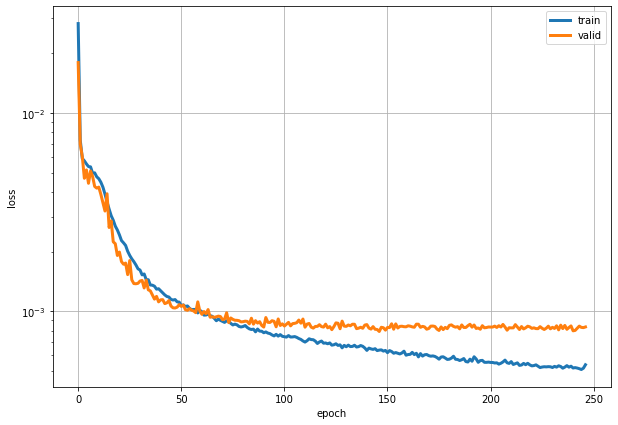

In [615]:
loss_plot('history/histCNN_DO_ES.json')

We obatain the same rasult with less steps

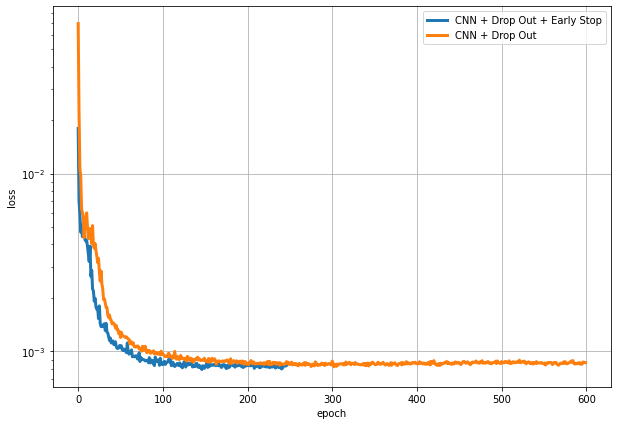

In [616]:
loss_comparison(['history/histCNN_DO_ES.json', 'history/histCNN_DO.json'], 
                ['CNN + Drop Out + Early Stop', 'CNN + Drop Out'])

In [497]:
Score('CNN + Drop Out + Early Stop', 'history/histCNN_DO_ES.json')


,Mse_Train,Mse_Val,Acc_Train,Acc_Val
FC,0.002701,0.004299,0.726051,0.721963
CNN,0.000269,0.001070,0.904790,0.789720
CNN + Drop Out,0.000371,0.000865,0.904790,0.810748
CNN + Drop Out + Early Stop,0.000538,0.000834,0.856893,0.822430


## DROP OUT + BATCH NORMALIZATION

Let's see what happens if we apply batch normalization to some layers output. I did it in the following way.

In [498]:
modCNN_DO_BN = CNN(DropOut=True, BatchNorm=True)
modCNN_DO_BN.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])

histCNN_DO_BN = modCNN_DO_BN.fit(X_train,y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(X_val, y_val))

27/27 [==============================] - 13s 484ms/step - loss: 0.3763 - accuracy: 0.1443 - val_loss: 0.0995 - val_accuracy: 0.0000e+00


In [617]:
model_summary('models/modelCNN_DO_BN.h5')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 96, 96, 16)        80        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 22, 22, 32)       

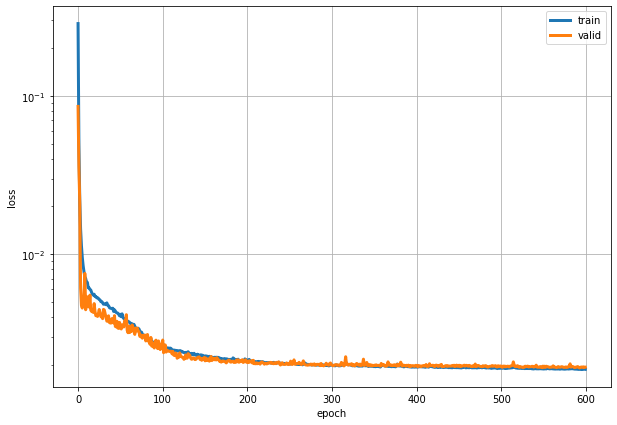

In [618]:
loss_plot('history/histCNN_DO_BN.json')

As we can see the model is worst. Maybe because BN is too aggressive for the actual configuration and we lose too much information.

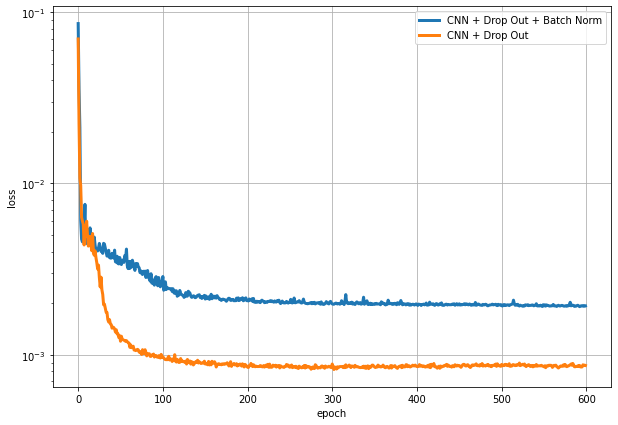

In [619]:
loss_comparison(['history/histCNN_DO_BN.json', 'history/histCNN_DO.json'], 
                ['CNN + Drop Out + Batch Norm', 'CNN + Drop Out'])

In [503]:
Score('CNN + Drop Out + Batch Norm', 'history/histCNN_DO_BN.json')


,Mse_Train,Mse_Val,Acc_Train,Acc_Val
FC,0.002701,0.004299,0.726051,0.721963
CNN,0.000269,0.001070,0.904790,0.789720
CNN + Drop Out,0.000371,0.000865,0.904790,0.810748
CNN + Drop Out + Early Stop,0.000538,0.000834,0.856893,0.822430
CNN + Drop Out + Batch Norm,0.001867,0.001926,0.743575,0.696262


## CNN + BATCH NORM
Apply just batch normalization without Drop Out, in this case is better

In [505]:
modCNN_BN = CNN(BatchNorm=True)
modCNN_BN.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])

histCNN_BN = modCNN_DO_BN.fit(X_train,y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(X_val, y_val))

27/27 [==============================] - 13s 481ms/step - loss: 0.0737 - accuracy: 0.2202 - val_loss: 0.0333 - val_accuracy: 0.3364


In [620]:
model_summary('models/modelCNN_BN.h5')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 96, 96, 16)        80        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 48, 48, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 44, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 18, 18, 64)       

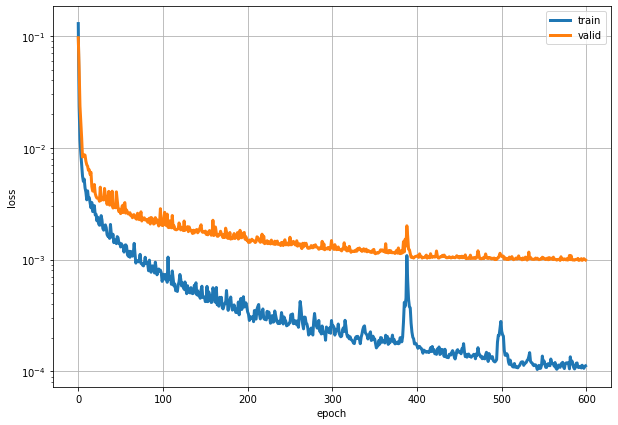

In [621]:
loss_plot('history/histCNN_BN.json')

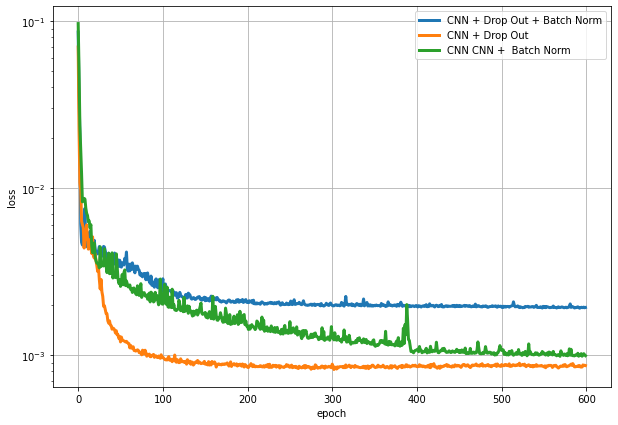

In [622]:
loss_comparison(['history/histCNN_DO_BN.json', 'history/histCNN_DO.json', 'history/histCNN_BN.json' ], 
                ['CNN + Drop Out + Batch Norm', 'CNN + Drop Out', 'CNN CNN +  Batch Norm'])

In [509]:
Score('CNN + Batch Norm', 'history/histCNN_BN.json')


,Mse_Train,Mse_Val,Acc_Train,Acc_Val
FC,0.002701,0.004299,0.726051,0.721963
CNN,0.000269,0.001070,0.904790,0.789720
CNN + Drop Out,0.000371,0.000865,0.904790,0.810748
CNN + Drop Out + Early Stop,0.000538,0.000834,0.856893,0.822430
CNN + Drop Out + Batch Norm,0.001867,0.001926,0.743575,0.696262
CNN + Batch Norm,0.000112,0.000992,0.946846,0.803738


##  <font color='red'> DATA AUGMENTATION



##     FLIPPED IMAGES
We rise the number of data adding new images: in this case flipping them horizontally we can double. 

Here the flip() function take into account the fact that mirroring will change the left labels to right labels.


In [623]:
def flip(y):
    y_f = y.copy()
    y_f[::2] = -y_f[::2]

    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    for a, b in flip_indices:
        y_f[a], y_f[b] = (
        y_f[b], y_f[a])
    
    return y_f

X, y = load()

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

In [624]:
y_f = np.array([flip(yi) for yi in y])
X_f = np.array([np.fliplr(Xi) for Xi in X])

X_full = np.r_[X, X_f]
y_full = np.r_[y, y_f]

X_full.shape, y_full.shape

((4280, 96, 96), (4280, 30))

Check if right eye remains right eye in both cases:

<function matplotlib.pyplot.show(close=None, block=None)>

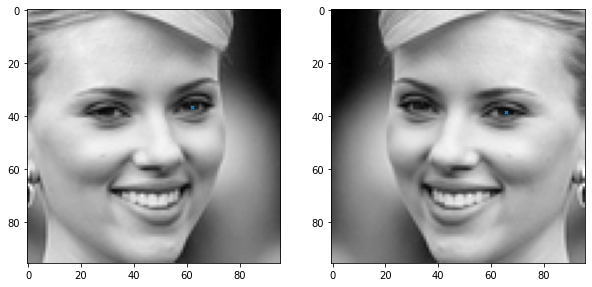

In [625]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


axes[0].imshow(X_full[12], cmap='gray')
axes[0].scatter(y_full[12][0::2][0] * 48 + 48, y_full[12][1::2][0] * 48 + 48, marker='x', s=10)

axes[1].imshow(X_full[12+X.shape[0]], cmap='gray')
axes[1].scatter(y_full[12+X.shape[0]][0::2][0] * 48 + 48, y_full[12+X.shape[0]][1::2][0] * 48 + 48, marker='x', s=10)

plt.show

Finally let's see how it improves the CNN + DO model

In [514]:
X_full = np.expand_dims(X_full, -1)

X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

modCNN_DO_FLIP = CNN(DropOut=True)

modCNN_DO_FLIP.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])

histCNN_DO_FLIP = modCNN_DO_FLIP.fit(X_train,y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(X_val, y_val))

54/54 [==============================] - 25s 454ms/step - loss: 0.0257 - accuracy: 0.4831 - val_loss: 0.0128 - val_accuracy: 0.6893


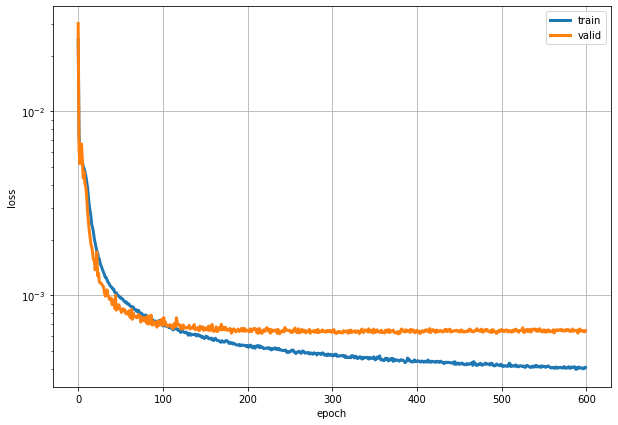

In [626]:
loss_plot('history/histCNN_DO_FLIP.json')

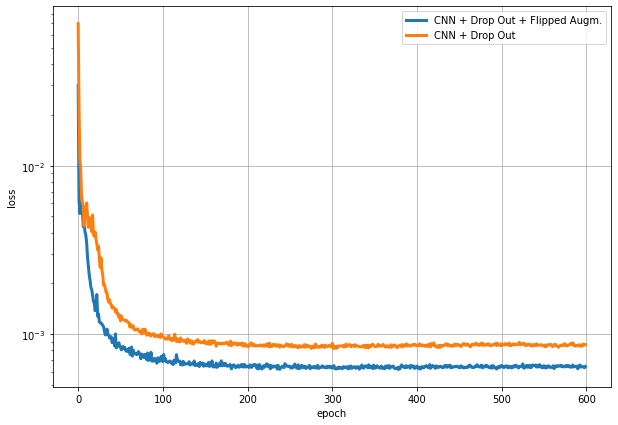

In [627]:
loss_comparison(['history/histCNN_DO_FLIP.json', 'history/histCNN_DO.json'], 
                ['CNN + Drop Out + Flipped Augm.', 'CNN + Drop Out'])

In [517]:
Score('CNN + Drop Out + Flipped Imgs', 'history/histCNN_DO_FLIP.json')


,Mse_Train,Mse_Val,Acc_Train,Acc_Val
FC,0.002701,0.004299,0.726051,0.721963
CNN,0.000269,0.001070,0.904790,0.789720
CNN + Drop Out,0.000371,0.000865,0.904790,0.810748
CNN + Drop Out + Early Stop,0.000538,0.000834,0.856893,0.822430
CNN + Drop Out + Batch Norm,0.001867,0.001926,0.743575,0.696262
CNN + Batch Norm,0.000112,0.000992,0.946846,0.803738
CNN + Drop Out + Flipped Imgs,0.000405,0.000643,0.883178,0.852804


CNN + DROP OUT + BATCH NORMALIZATION

In [518]:
modCNN_DO_BN_FLIP = CNN(DropOut=True, BatchNorm=True)

modCNN_DO_BN_FLIP.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])

histCNN_DO_BN_FLIP = modCNN_DO_BN_FLIP.fit(X_train,y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(X_val, y_val))

54/54 [==============================] - 28s 527ms/step - loss: 0.2131 - accuracy: 0.2132 - val_loss: 0.0306 - val_accuracy: 0.6893


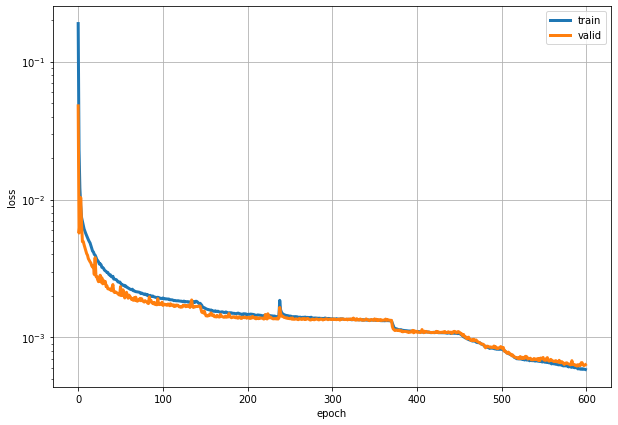

In [628]:
loss_plot('history/histCNN_DO_BN_FLIP.json')

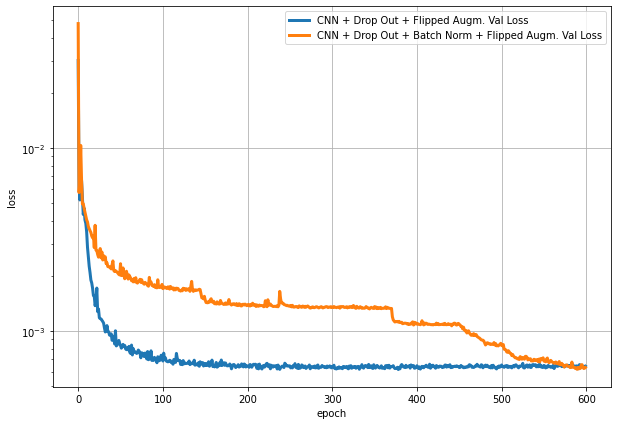

In [521]:
loss_comparison(['history/histCNN_DO_FLIP.json', 'history/histCNN_DO_BN_FLIP.json'], 
                ['CNN + Drop Out + Flipped Augm. Val Loss', 'CNN + Drop Out + Batch Norm + Flipped Augm. Val Loss'])

As we can see, adding information to the model, the batch normalization, even if small, improve the accuracy.

In [522]:
Score('CNN + Drop Out + Batch Norm + Flipped Imgs', 'history/histCNN_DO_BN_FLIP.json')


,Mse_Train,Mse_Val,Acc_Train,Acc_Val
FC,0.002701,0.004299,0.726051,0.721963
CNN,0.000269,0.001070,0.904790,0.789720
CNN + Drop Out,0.000371,0.000865,0.904790,0.810748
CNN + Drop Out + Early Stop,0.000538,0.000834,0.856893,0.822430
CNN + Drop Out + Batch Norm,0.001867,0.001926,0.743575,0.696262
CNN + Batch Norm,0.000112,0.000992,0.946846,0.803738
CNN + Drop Out + Flipped Imgs,0.000405,0.000643,0.883178,0.852804
CNN + Drop Out + Batch Norm + Flipped Imgs,0.000585,0.000633,0.849883,0.858645


## PIXELS BRIGHTNESS


We can augment the data in several ways (shifting, rotating, adding noise...) but always taking into account the transformation of the labels. Here we change the brightness of the images. 

In [523]:
def MoreBrigth(x): return np.clip(x*1.4, 0.0, 1.0)
def LessBrigth(x): return np.clip(x*0.3, 0.0, 1.0)

y_f = np.array([flip(yi) for yi in y])
X_f = np.array([np.fliplr(Xi) for Xi in X])
X_full = np.r_[X, X_f]
y_full = np.r_[y, y_f]

X_plus = np.array([MoreBrigth(Xi) for Xi in X_full])
X_less = np.array([LessBrigth(Xi) for Xi in X_full])
X_bright = np.r_[X_plus, X_less]
y_bright = np.r_[y_full, y_full]

X_full2 = np.r_[X_full, X_bright]
y_full2 = np.r_[y_full, y_bright]
X_full2.shape, y_full2.shape

((12840, 96, 96), (12840, 30))

<function matplotlib.pyplot.show(close=None, block=None)>

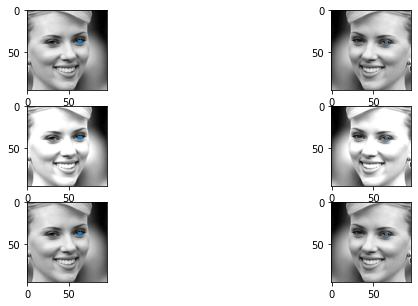

In [524]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 5))


axes[0,0].imshow(X_full2[12], cmap='gray')
axes[0,0].scatter(y_full2[12][0::2][0] * 48 + 48, y_full[12][1::2][0] * 48 + 48, marker='x', s=10)

axes[0,1].imshow(X_full2[12+X.shape[0]], cmap='gray')
axes[0,1].scatter(y_full2[12+X.shape[0]][0::2][0] * 48 + 48, y_full2[12+X.shape[0]][1::2][0] * 48 + 48, marker='x', s=10)

axes[1,0].imshow(X_full2[12+2*X.shape[0]], cmap='gray')
axes[1,0].scatter(y_full2[12+2*X.shape[0]][0::2][0] * 48 + 48, y_full2[12+2*X.shape[0]][1::2][0] * 48 + 48, marker='x', s=10)

axes[1,1].imshow(X_full2[12+3*X.shape[0]], cmap='gray')
axes[1,1].scatter(y_full2[12+3*X.shape[0]][0::2][0] * 48 + 48, y_full2[12+3*X.shape[0]][1::2][0] * 48 + 48, marker='x', s=10)

axes[2,0].imshow(X_full2[12+4*X.shape[0]], cmap='gray')
axes[2,0].scatter(y_full2[12+4*X.shape[0]][0::2][0] * 48 + 48, y_full2[12+4*X.shape[0]][1::2][0] * 48 + 48, marker='x', s=10)

axes[2,1].imshow(X_full2[12+5*X.shape[0]], cmap='gray')
axes[2,1].scatter(y_full2[12+5*X.shape[0]][0::2][0] * 48 + 48, y_full2[12+5*X.shape[0]][1::2][0] * 48 + 48, marker='x', s=10)

plt.show

In [525]:
X_full2 = np.expand_dims(X_full2, -1)
X_train, X_val, y_train, y_val = train_test_split(X_full2, y_full2, test_size=0.2, random_state=42)

modCNN_DO_FLIP_BRIGHT = CNN(DropOut=True)
modCNN_DO_FLIP_BRIGHT.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])

histCNN_DO_FLIP_BRIGHT = modCNN_DO_FLIP_BRIGHT.fit(X_train,y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data=(X_val, y_val))

161/161 [==============================] - 83s 514ms/step - loss: 0.0134 - accuracy: 0.5939 - val_loss: 0.0055 - val_accuracy: 0.6756


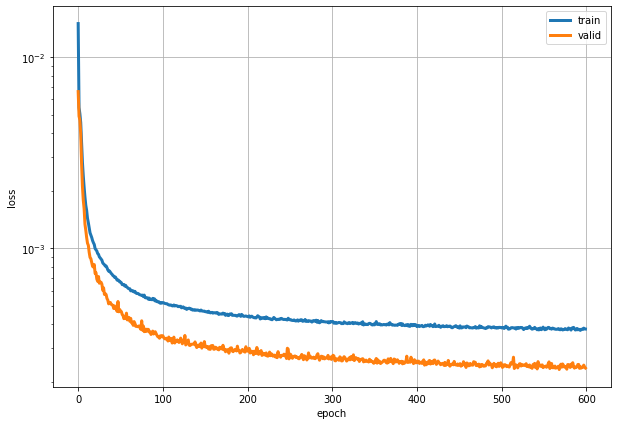

In [629]:
loss_plot('history/histCNN_DO_FLIP_BRIGHT.json')

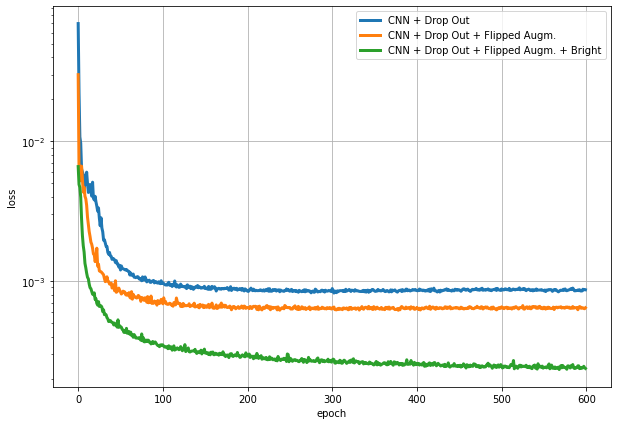

In [630]:
loss_comparison(['history/histCNN_DO.json', 'history/histCNN_DO_FLIP.json', 'history/histCNN_DO_FLIP_BRIGHT.json'], 
                ['CNN + Drop Out','CNN + Drop Out + Flipped Augm.', 'CNN + Drop Out + Flipped Augm. + Bright'])

We improve the accuracy obtaining better predictions.

In [531]:
Score('CNN + Drop Out + Flipped Imgs + Bright Imgs', 'history/histCNN_DO_FLIP_BRIGHT.json')


,Mse_Train,Mse_Val,Acc_Train,Acc_Val
FC,0.002701,0.004299,0.726051,0.721963
CNN,0.000269,0.001070,0.904790,0.789720
CNN + Drop Out,0.000371,0.000865,0.904790,0.810748
CNN + Drop Out + Early Stop,0.000538,0.000834,0.856893,0.822430
CNN + Drop Out + Batch Norm,0.001867,0.001926,0.743575,0.696262
CNN + Batch Norm,0.000112,0.000992,0.946846,0.803738
CNN + Drop Out + Flipped Imgs,0.000405,0.000643,0.883178,0.852804
CNN + Drop Out + Batch Norm + Flipped Imgs,0.000585,0.000633,0.849883,0.858645
CNN + Drop Out + Flipped Imgs + Bright Imgs,0.000378,0.000236,0.878505,0.905374


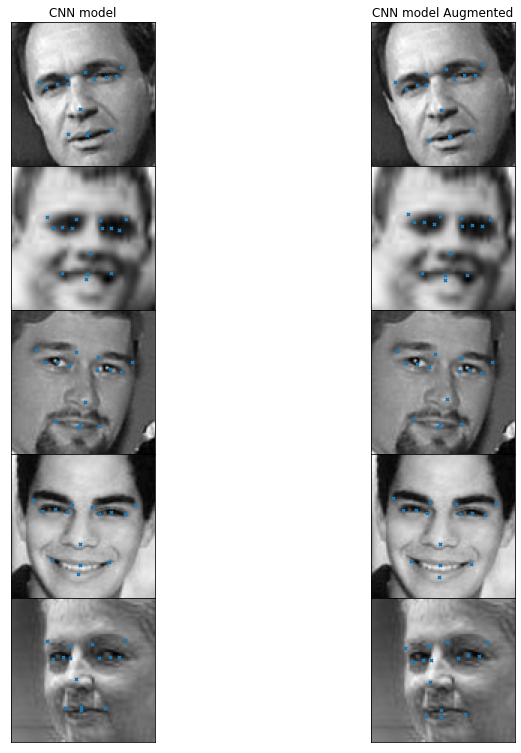

In [533]:
#X_test ,_ = load2d(test=True)

y_predCNNFB = model_predict('models/modelCNN_DO_FLIP_BRIGHT.h5', X_test)

image_compare(y_predCNN, y_predCNNFB, "CNN model", "CNN model Augmented")

## Adding preprocessing
Let's see if adding some preprocessing we improve the model. In this case I used the exposure normalization function.

In [574]:
from skimage import exposure
from keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(patience=100)
callback_setting_LR = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, mode='auto', 
                                      min_delta=0.0001, cooldown=10, min_lr=0.000001)]

def normalise_color_intensity(images):
    normalised_images = []
    for image in images:
        normalised_images.append(exposure.equalize_hist(image))

    return np.array(normalised_images)

Xfull_pp = normalise_color_intensity(X_full2)
X_trainpp, X_valpp, y_train, y_val = train_test_split(Xfull_pp, y_full2, test_size=0.2, random_state=42)

batch_size = 64
epochs = 1

modCNN_DO_FLIP_BRIGHT_PP = CNN(DropOut=True)

modCNN_DO_FLIP_BRIGHT_PP.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

histCNN_DO_FLIP_BRIGHT_PP = modCNN_DO_FLIP_BRIGHT_PP.fit(X_trainpp, y_train,
                   batch_size=batch_size,
                   epochs=epochs, callbacks = [callback_setting_LR, early_stop],
                   validation_data=(X_valpp, y_val))

/Users/pablogranatiero/opt/anaconda3/envs/env_prova/lib/python3.8/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


161/161 [==============================] - 98s 607ms/step - loss: 0.0105 - accuracy: 0.6031 - val_loss: 0.0058 - val_accuracy: 0.6756


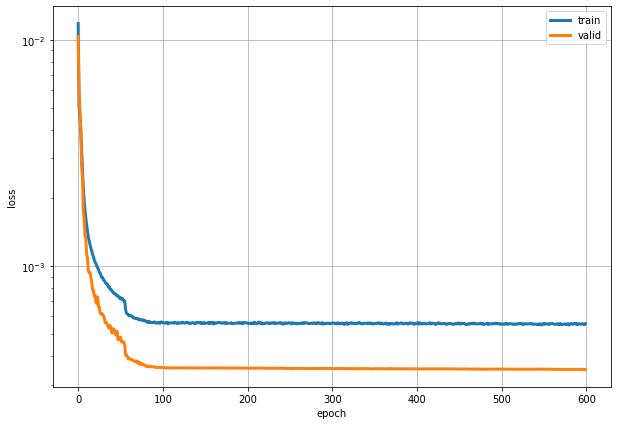

In [631]:
loss_plot('history/histCNN_PP.json')

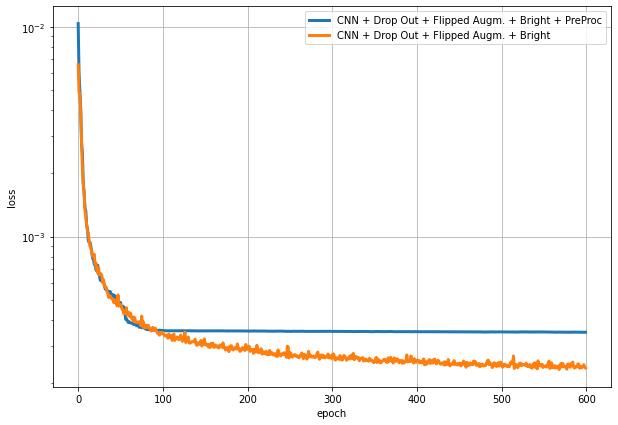

In [632]:
loss_comparison(['history/histCNN_PP.json', 'history/histCNN_DO_FLIP_BRIGHT.json'], 
                ['CNN + Drop Out + Flipped Augm. + Bright + PreProc', 'CNN + Drop Out + Flipped Augm. + Bright'])

We can speed up the model using the ImageDataGenerator class, after having modified it for the labels. It generates an iterator with a batch of modified imageges chosen from the original data set.

In [540]:
from keras.preprocessing.image import ImageDataGenerator
class FlippedImageDataGenerator(ImageDataGenerator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def next(self):
        X_batch, y_batch = super(FlippedImageDataGenerator, self).next()
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]

        if y_batch is not None:
            
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1

            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )

        return X_batch, y_batch
    
X, y = load2d()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
model_CNN_GEN = CNN(DropOut=True)    
gen = FlippedImageDataGenerator(brightness_range=(0.5,1.5))

model_CNN_GEN.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])


hist_CNN_GEN = model_CNN_GEN.fit_generator(gen.flow(X_train, y_train, batch_size=64),
                             steps_per_epoch = X_train.shape[0]//batch_size,
                             epochs=epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stop])    

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

## <font color='red'> SPECIALIST MODELS

The last model we will see is made by six sumbmodels specialized in detect a specific part of the face. We split one task in six subtasks. In this way we will have much more available data.

In [634]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

def flip2(y, flip_indices):
    
    y_f = y.copy()
    y_f[::2] = -y_f[::2]

    for a, b in flip_indices:
        y_f[a], y_f[b] = (
        y_f[b], y_f[a])
    
    return y_f   

from skimage import exposure
def normalise_color_intensity(images):
    normalised_images = []
    for image in images:
        normalised_images.append(exposure.equalize_hist(image))

    return np.array(normalised_images)

We run the model in two ways: 

-training zero six different models, where the architecture is the same except the last layer and last layer gives as output the dimension of the subtask vector.

-use a pretrained model, and train just the last layer weights for the specific sub task. Of course this is much faster. 

In [635]:
def CNN_less_last(DropOut=False, BatchNorm=False):
    model = Sequential()

    model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same",activation="relu",input_shape=(96,96,1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if DropOut == True:
        model.add(Dropout(0.1))
    if BatchNorm == True:
        model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=(5,5) ,activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if DropOut == True:
        model.add(Dropout(0.1))
    if BatchNorm == True:
        model.add(BatchNormalization())  

    model.add(Conv2D(64, kernel_size=(5,5) ,activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if DropOut == True:
        model.add(Dropout(0.2))
    if BatchNorm == True:
        model.add(BatchNormalization())  

    model.add(Conv2D(128, kernel_size=(3,3),activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if DropOut == True:
        model.add(Dropout(0.3))
    if BatchNorm == True:
        model.add(BatchNormalization())  

    model.add(Flatten())
    model.add(Dense(500, activation="relu"))
    if DropOut == True:
        model.add(Dropout(0.4))

    model.add(Dense(128, activation="relu"))

    return(model)

def specialized(epochs, batch_size, number_col):
    cols = SPECIALIST_SETTINGS[number_col]['columns']
        
    Xy = load(cols=cols)
    X = Xy[0] ; y = Xy[1]
    y_f = np.array([flip2(yi, SPECIALIST_SETTINGS[number_col]['flip_indices']) for yi in y])
    X_f = np.array([np.fliplr(Xi) for Xi in X])
    X_full = np.r_[X, X_f]
    y_full = np.r_[y, y_f]
    X_full = np.expand_dims(X_full, -1)

    X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=44)
        
    model_sp = CNN_less_last(DropOut=True)
        #model_sp.outputs = [model_sp.layers[-1].output]
        #model_sp.layers[-1].outbounds_nodes = []
    model_sp.add(Dense(len(cols)))

    model_sp.compile(loss='mse', optimizer='nadam', metrics=['accuracy'])

    print("Training model for columns {} for {} epochs".format(cols, epochs))
    
    early_stop = EarlyStopping(patience=100)
    flipgen = ImageDataGenerator(brightness_range=(0.2,2.0))
    
    hist_sp = model_sp.fit_generator(flipgen.flow(X_train, y_train, batch_size=32),
                             steps_per_epoch = X_train.shape[0]/batch_size,
                             epochs=epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stop])
    return model_sp, hist_sp

In [543]:
model_sps = []
hist_sps = []

for i in range(len(SPECIALIST_SETTINGS)):
    model_sp, hist_sp = specialized(1, 64, i)
    model_sps.append(model_sp)
    hist_sps.append(hist_sp)

There are missing points:
left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 1 epochs
176/175 [==============================] - 59s 333ms/step - loss: 18.7945 - accuracy: 0.7322 - val_loss: 0.0702 - val_accuracy: 0.9982
There are missing points:
nose_tip_x    7049
nose_tip_y    7049
Image         7049
dtype: int64
Training model for columns ('nose_tip_x', 'nose_tip_y') for 1 epochs
177/176 [==============================] - 59s 335ms/step - loss: 32.7806 - accuracy: 0.6510 - val_loss: 0.0569 - val_accuracy: 0.9787
There are missing points:
mouth_left_corner_x       2269
mouth_left_corner_y       2269
mouth_right_corner_x      2270
mouth_right_corner_y      2270
mouth_center_top_lip_x    2275
mouth_center_top_lip_y    2275
Image                     7049
dtype: int64
Training

In [636]:
modelsp0 = load_model("models/model_sp0.h5")

modelsp1 = load_model("models/model_sp1.h5")

modelsp2 = load_model("models/model_sp2.h5")

modelsp3 = load_model("models/model_sp3.h5")

modelsp4 = load_model("models/model_sp4.h5")

modelsp5 = load_model("models/model_sp5.h5")

model_sps1 = [modelsp0, modelsp1, modelsp2,
           modelsp3, modelsp4, modelsp5]

hist_sps1 = ['history/hist_sp0.json', 'history/hist_sp1.json', 'history/hist_sp2.json',
           'history/hist_sp3.json', 'history/hist_sp4.json', 'history/hist_sp5.json']

cols_list = []
for i in SPECIALIST_SETTINGS:
    cols_list.append(i['columns'][0])

In [547]:
def specialized2(pre_model, number_col, epochs, batch_size):
    
    cols = SPECIALIST_SETTINGS[number_col]['columns']
    
    Xy = load(cols=cols)
    X = Xy[0] ; y = Xy[1]
    y_f = np.array([flip2(yi, SPECIALIST_SETTINGS[number_col]['flip_indices']) for yi in y])
    X_f = np.array([np.fliplr(Xi) for Xi in X])
    X_full = np.r_[X, X_f]
    y_full = np.r_[y, y_f]
    X_full = np.expand_dims(X_full, -1)

    X_plus = np.array([MoreBrigth(Xi) for Xi in X_full])
    X_less = np.array([LessBrigth(Xi) for Xi in X_full])
    X_bright = np.r_[X_plus, X_less]
    y_bright = np.r_[y_full, y_full]

    X_full2 = np.r_[X_full, X_bright]
    y_full2 = np.r_[y_full, y_bright]
    
    #i'm using as input the forward propagation of the penultimate layer.
    inputmodel = Model(inputs=pre_model.inputs, outputs=pre_model.layers[-2].output)
    inps = inputmodel.predict(X_full2)
    
    X_train, X_val, y_train, y_val = train_test_split(inps, y_full2, test_size=0.2, random_state=44)
    
    model = Sequential()

    model.add(Dense(len(cols), input_dim=128))
              
    model.compile(loss='mse', optimizer='adam')
    
    early_stop = EarlyStopping(patience=100)    
    print("Training model for columns {} for {} epochs".format(cols, epochs))
    hist = model.fit(X_train, y_train, batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(X_val, y_val),
                             callbacks=[early_stop])
    return model, hist

In [549]:
pre_model = load_model('models/modelCNN_DO_FLIP_BRIGHT.h5') 

model_sps2 = []
hist_sps2 = []

for i in range(len(SPECIALIST_SETTINGS)):
    model_sp, hist_sp = specialized2(pre_model, i, 600, 64)
    model_sps2.append(model_sp)
    hist_sps2.append(hist_sp)

There are missing points:
left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 600 epochs
Epoch 1/600
528/528 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0050
Epoch 2/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 3/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 4/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 5/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/600
528/528 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/600
528/528 [==============================] - 1s 2ms/step - loss: 0.0023 - val_los

528/528 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 79/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 80/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 81/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 82/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 83/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 84/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 85/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 86/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 87/600
528/528 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 

529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 30/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 31/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 32/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 33/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 34/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 35/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 36/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 37/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 38/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 

529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 110/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 111/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 112/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 113/600
529/529 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 114/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 115/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 116/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 117/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 118/600
529/529 [==============================] - 1s 1ms/step - loss: 0.0043 - v

170/170 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0162
Epoch 2/600
170/170 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0073
Epoch 3/600
170/170 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 4/600
170/170 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 5/600
170/170 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 6/600
170/170 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 7/600
170/170 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 8/600
170/170 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/600
170/170 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 10/600
170/170 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0013
E

Epoch 77/600
170/170 [==============================] - 0s 2ms/step - loss: 7.8455e-04 - val_loss: 5.9427e-04
Epoch 78/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8972e-04 - val_loss: 5.7336e-04
Epoch 79/600
170/170 [==============================] - 0s 1ms/step - loss: 7.7861e-04 - val_loss: 5.6299e-04
Epoch 80/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8075e-04 - val_loss: 5.6396e-04
Epoch 81/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8530e-04 - val_loss: 5.7218e-04
Epoch 82/600
170/170 [==============================] - 0s 1ms/step - loss: 7.7912e-04 - val_loss: 5.6493e-04
Epoch 83/600
170/170 [==============================] - 0s 2ms/step - loss: 7.7770e-04 - val_loss: 5.7137e-04
Epoch 84/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8059e-04 - val_loss: 5.8643e-04
Epoch 85/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8227e-04 - val_loss: 5.6368e-04
Epoch 86/6

170/170 [==============================] - 0s 1ms/step - loss: 7.7953e-04 - val_loss: 5.7034e-04
Epoch 152/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8201e-04 - val_loss: 5.5283e-04
Epoch 153/600
170/170 [==============================] - 0s 1ms/step - loss: 7.7814e-04 - val_loss: 5.5438e-04
Epoch 154/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8262e-04 - val_loss: 5.6504e-04
Epoch 155/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8131e-04 - val_loss: 5.6151e-04
Epoch 156/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8221e-04 - val_loss: 5.7040e-04
Epoch 157/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8456e-04 - val_loss: 5.6208e-04
Epoch 158/600
170/170 [==============================] - 0s 1ms/step - loss: 7.8685e-04 - val_loss: 5.6242e-04
Epoch 159/600
170/170 [==============================] - 0s 1ms/step - loss: 7.7795e-04 - val_loss: 5.5424e-04
Epoch 160/600
1

527/527 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 66/600
527/527 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 67/600
527/527 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 68/600
527/527 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 69/600
527/527 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 70/600
527/527 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 71/600
527/527 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 72/600
527/527 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 73/600
527/527 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 74/600
527/527 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 

169/169 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0078
Epoch 2/600
169/169 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 3/600
169/169 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 4/600
169/169 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 5/600
169/169 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/600
169/169 [==============================] - 0s 941us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/600
169/169 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 9.5825e-04
Epoch 8/600
169/169 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 8.0508e-04
Epoch 9/600
169/169 [==============================] - 0s 1ms/step - loss: 9.8351e-04 - val_loss: 7.1476e-04
Epoch 10/600
169/169 [==============================] - 0s 1ms/step - loss: 8.9933e-0

169/169 [==============================] - 0s 1ms/step - loss: 5.8004e-04 - val_loss: 3.8572e-04
Epoch 77/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7889e-04 - val_loss: 3.9111e-04
Epoch 78/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7961e-04 - val_loss: 3.8671e-04
Epoch 79/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7709e-04 - val_loss: 3.7714e-04
Epoch 80/600
169/169 [==============================] - 0s 1ms/step - loss: 5.8312e-04 - val_loss: 3.8372e-04
Epoch 81/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7768e-04 - val_loss: 3.8377e-04
Epoch 82/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7982e-04 - val_loss: 3.9795e-04
Epoch 83/600
169/169 [==============================] - 0s 1ms/step - loss: 5.8220e-04 - val_loss: 3.7972e-04
Epoch 84/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7818e-04 - val_loss: 3.8251e-04
Epoch 85/600
169/169 [=

169/169 [==============================] - 0s 1ms/step - loss: 5.7943e-04 - val_loss: 3.7287e-04
Epoch 151/600
169/169 [==============================] - 0s 1ms/step - loss: 5.8076e-04 - val_loss: 3.8500e-04
Epoch 152/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7798e-04 - val_loss: 3.8853e-04
Epoch 153/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7825e-04 - val_loss: 3.8972e-04
Epoch 154/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7915e-04 - val_loss: 3.7910e-04
Epoch 155/600
169/169 [==============================] - 0s 1ms/step - loss: 5.8079e-04 - val_loss: 3.8622e-04
Epoch 156/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7805e-04 - val_loss: 3.7815e-04
Epoch 157/600
169/169 [==============================] - 0s 1ms/step - loss: 5.8001e-04 - val_loss: 3.8243e-04
Epoch 158/600
169/169 [==============================] - 0s 2ms/step - loss: 5.7829e-04 - val_loss: 3.8173e-04
Epoch 159/600
1

Epoch 224/600
169/169 [==============================] - 0s 1ms/step - loss: 5.8326e-04 - val_loss: 3.9817e-04
Epoch 225/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7937e-04 - val_loss: 3.8258e-04
Epoch 226/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7871e-04 - val_loss: 3.8682e-04
Epoch 227/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7746e-04 - val_loss: 3.8057e-04
Epoch 228/600
169/169 [==============================] - 0s 1ms/step - loss: 5.8557e-04 - val_loss: 3.8525e-04
Epoch 229/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7628e-04 - val_loss: 3.8882e-04
Epoch 230/600
169/169 [==============================] - 0s 1ms/step - loss: 5.8102e-04 - val_loss: 3.9237e-04
Epoch 231/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7695e-04 - val_loss: 3.8087e-04
Epoch 232/600
169/169 [==============================] - 0s 1ms/step - loss: 5.7628e-04 - val_loss: 3.7480e-04
E

165/165 [==============================] - 0s 1ms/step - loss: 6.9107e-04 - val_loss: 8.8600e-04
Epoch 45/600
165/165 [==============================] - 0s 1ms/step - loss: 6.9285e-04 - val_loss: 8.7310e-04
Epoch 46/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8698e-04 - val_loss: 8.5392e-04
Epoch 47/600
165/165 [==============================] - 0s 1ms/step - loss: 6.9189e-04 - val_loss: 8.6171e-04
Epoch 48/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8978e-04 - val_loss: 8.6830e-04
Epoch 49/600
165/165 [==============================] - 0s 2ms/step - loss: 6.9565e-04 - val_loss: 8.6325e-04
Epoch 50/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8923e-04 - val_loss: 8.5449e-04
Epoch 51/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8962e-04 - val_loss: 8.6652e-04
Epoch 52/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8988e-04 - val_loss: 8.7234e-04
Epoch 53/600
165/165 [=

165/165 [==============================] - 0s 2ms/step - loss: 6.8768e-04 - val_loss: 8.5824e-04
Epoch 119/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8990e-04 - val_loss: 8.8464e-04
Epoch 120/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8703e-04 - val_loss: 8.5942e-04
Epoch 121/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8730e-04 - val_loss: 8.6309e-04
Epoch 122/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8740e-04 - val_loss: 8.5900e-04
Epoch 123/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8798e-04 - val_loss: 8.6826e-04
Epoch 124/600
165/165 [==============================] - 0s 2ms/step - loss: 6.8964e-04 - val_loss: 8.6252e-04
Epoch 125/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8648e-04 - val_loss: 8.5975e-04
Epoch 126/600
165/165 [==============================] - 0s 2ms/step - loss: 6.8818e-04 - val_loss: 8.6350e-04
Epoch 127/600
1

Epoch 192/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8689e-04 - val_loss: 8.7018e-04
Epoch 193/600
165/165 [==============================] - 0s 2ms/step - loss: 6.8897e-04 - val_loss: 8.8940e-04
Epoch 194/600
165/165 [==============================] - 0s 2ms/step - loss: 6.9377e-04 - val_loss: 8.6491e-04
Epoch 195/600
165/165 [==============================] - 0s 2ms/step - loss: 6.8876e-04 - val_loss: 8.6790e-04
Epoch 196/600
165/165 [==============================] - 0s 2ms/step - loss: 6.8665e-04 - val_loss: 8.6794e-04
Epoch 197/600
165/165 [==============================] - 0s 2ms/step - loss: 6.8795e-04 - val_loss: 8.8623e-04
Epoch 198/600
165/165 [==============================] - 0s 2ms/step - loss: 6.9004e-04 - val_loss: 8.6001e-04
Epoch 199/600
165/165 [==============================] - 0s 1ms/step - loss: 6.9226e-04 - val_loss: 8.5718e-04
Epoch 200/600
165/165 [==============================] - 0s 1ms/step - loss: 6.8639e-04 - val_loss: 8.5549e-04
E

As we can see the second strategy seems to work better, but both model seems to have problem in detecting nose and mouth center (that have in common the small dimensionality). 

Here the validation losses for the model 1

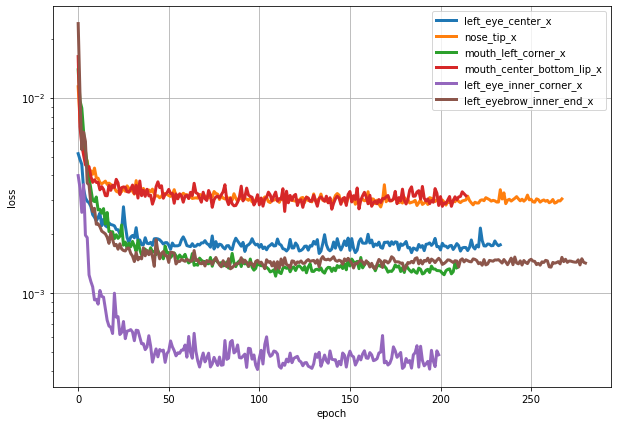

In [637]:
loss_comparison(hist_sps1, cols_list)

Here the validation losses for the model 2

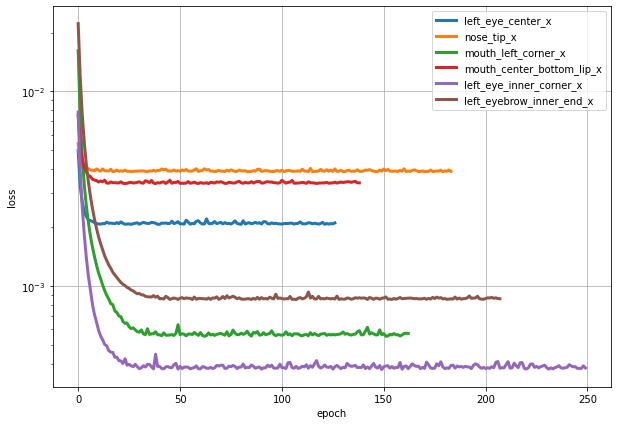

In [566]:
N = len(hist_sps2) ; loss = []
for i in range(N):
    loss.append(hist_sps2[i].history['val_loss'])
fig = plt.figure(figsize=(10,7))
for i in range(N):
    plt.plot(loss[i], linewidth=3, label=cols_list[i])
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log') 
plt.show()

In [567]:
def predict_specialist(Models, X_test):
    y_pred_s = [] ; df_y_pred = pd.DataFrame() 
    for i in range(len(SPECIALIST_SETTINGS)):
        y_pred = Models[i].predict(X_test)
        y_pred = DataFrame(y_pred,columns=SPECIALIST_SETTINGS[i]['columns'])
        y_pred_s.append(y_pred)
    for y in y_pred_s:
        df_y_pred = pd.concat([df_y_pred, y], axis=1, sort=False)    
    return(df_y_pred)

def predict_specialist2(pre_model, Models, X_test):
    y_pred_s = [] ; df_y_pred = pd.DataFrame()
    inputmodel = Model(inputs=pre_model.inputs, outputs=pre_model.layers[-2].output)
    inps = inputmodel.predict(X_test)
    for i in range(len(SPECIALIST_SETTINGS)):
        y_pred = Models[i].predict(inps)
        y_pred = DataFrame(y_pred,columns=SPECIALIST_SETTINGS[i]['columns'])
        y_pred_s.append(y_pred)
    for y in y_pred_s:
        df_y_pred = pd.concat([df_y_pred, y], axis=1, sort=False)    
    return(df_y_pred)


As we can see the result is not that good and some problem with the noses and the mouth arise.

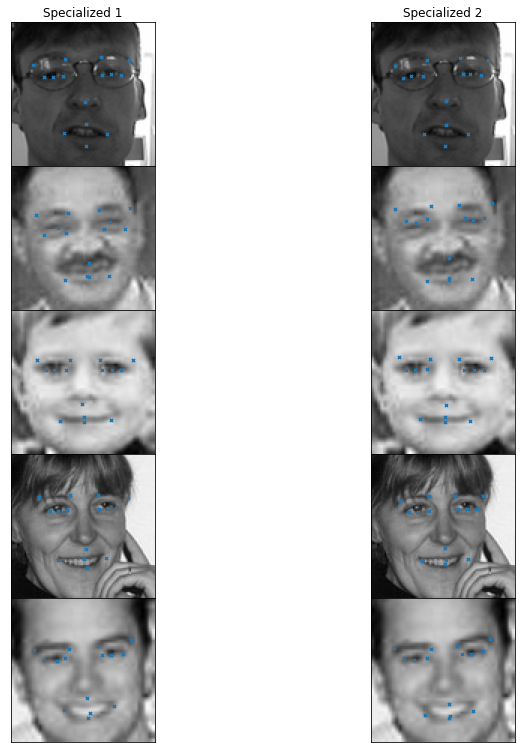

In [568]:
y_pred1 = predict_specialist(model_sps1, X_test).values

pre_model = load_model('models/modelCNN_DO_FLIP_BRIGHT.h5') 
y_pred2 = predict_specialist2(pre_model, model_sps2, X_test).values

image_compare(y_pred1, y_pred2, "Specialized 1", "Specialized 2")

We conclude looking at the best model I found predictions. That is the CNN with augmented data and Drop Out.

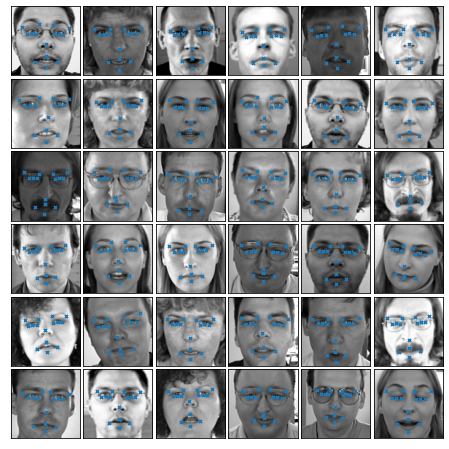

In [570]:
y_pred = model_predict('models/modelCNN_DO_FLIP_BRIGHT.h5', X_test)

    
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(36):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    plot_sample2(X_test[i], y_pred[i], ax)

plt.show()

Let's see his Kaggle score:

In [573]:
lookup = pd.read_csv('IdLookupTable.csv')

lookid_list = list(lookup['FeatureName'])
imageID = list(lookup['ImageId']-1)
pre_list = list(y_pred)

rowid = lookup['RowId']
rowid=list(rowid)
len(rowid)

feature = []
for f in list(lookup['FeatureName']):
    feature.append(lookid_list.index(f))
    preded = []
for x,y in zip(imageID,feature):
    preded.append(y_pred[x][y])

rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)

submission['Location'] = submission['Location']  * 48 + 48
submission.to_csv('submission_CNNDO.csv',index = False)
submission.head()

,RowId,Location
0,1,66.237409
1,2,37.387007
2,3,28.642837
3,4,36.646635
4,5,59.741160


And the score is 2.79197